# Prey notebook

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import neat
import matplotlib.pyplot as plt

import pickle
import multimodal_mazes
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ideas 

* Odour - constant but noisy. 
* Sound - reliable but infrequent.
* Rather than resetting the env to zero every step, you could decay it. E.g. env[:,:,:-1] *= 0.8 + blur. 
* Analysis: n_prey caught, speed, costs (e.g. movement vs food). 
* Evolve prey against different algorithms. Then, evolve predators against these prey.   

## Rule-based Agents

In [8]:
# Hyperparameters 
width=11
height=5
n_prey = 1
n_steps = 50
n_trials = 100
pk = 5 # the width of the prey's Gaussian signal (in rc)
visible_steps = n_steps
scenario = "Random"
motion = "Levy"
multisensory = "Broad"

if scenario == "Static":
    pc = 0.0
    pm = None
    pe = None 
    motion = None
elif scenario == "Constant" and motion == "Linear":
    pc = 0.0
    pm = 0.5
    pe = 0.2
elif scenario == "Constant" and motion == "Disappearing":
    pc = 0.0
    pm = 0.5
    pe = 0.2
    visible_steps = 3
    case = "2"
elif scenario == "Random":
    pc = 0.0
    pm = 1
    pe = 0.2
    motion = "Levy"
    case = "1"

### Fitness vs noise

In [ ]:
# Fitness vs noise
noises = np.linspace(start=0.0, stop=2.0, num=10)
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
results = np.zeros((len(noises), len(policies)))

# Test agents
for a, noise in enumerate(tqdm(noises)):

    for b, policy in enumerate(policies): 
        if policy in multimodal_mazes.AgentRuleBased.policies:
            agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
        elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
            agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
            agnt.alpha = 0.6
        elif policy == "Levy":
            agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

        fitness, _, _, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case="2 L", motion=motion, pc=pc, pm=pm, pe=pe)

        results[a, b] = fitness

for b, policy in enumerate(policies): 
    plt.plot(noises, results[:,b], color=colors[b], label=policy)

plt.ylim([0, 1.05])
plt.ylabel('Fitness')
plt.xlabel('Sensor Noise')
plt.legend()

In [ ]:
# Fitness vs noise AUC 
auc = np.trapz(y=results.T, x=noises, axis=1)
for b, _ in enumerate(policies): 
    ml, sl, _ = plt.stem(b, auc[b] - auc[0])
    ml.set_color(colors[b])
    sl.set_color(colors[b])
plt.xticks(range(len(policies)), policies, rotation='vertical')
plt.ylabel('AUC');

### Prey initial position vs capture time

In [ ]:
# Prey initial position vs capture time
noise = 0
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for b, policy in enumerate(policies): 
    if policy in multimodal_mazes.AgentRuleBased.policies:
        agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
    elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
        agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
        agnt.alpha = 0.6
    elif policy == "Levy":
        agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

    _, times, _, preys = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case="", motion=motion, pc=pc, pm=pm, pe=pe) 

    percentage_results = []
    capture_results = {str(key):[0,0] for key in range(pk//2, width+pk//2)}
    
    for prey in preys:
        if prey[0].state == 0:
            capture_results[str(prey[0].path[0][1])][1] += 1
        capture_results[str(prey[0].path[0][1])][0] += 1
    
    for key,value in capture_results.items():
        percentage = 0
        if value[0] != 0:
            percentage = (value[1]/value[0])*100
        percentage_results.append([int(key), percentage])
    
    percentage_results = sorted(percentage_results)
    percentage_positions = [percentage_results[it][0] for it in range(len(percentage_results))]
    percentages = [percentage_results[it][1] for it in range(len(percentage_results))]

    time_results = sorted([[preys[result][0].path[0][1], times[result]] for result in range(len(preys))]) # uncaptured prey have time set to maximum
    time_positions = [time_results[it][0] for it in range(len(time_results))]
    sorted_times = [time_results[it][1] for it in range(len(time_results))]
    
    curve1 = np.poly1d(np.polyfit(time_positions, sorted_times, deg=2))
    y1 = curve1(time_positions) 
    y1[y1 <= 2] = 2
    ax1.plot(time_positions, y1, color=colors[b], label=policies[b])

    curve2 = np.poly1d(np.polyfit(percentage_positions, percentages, deg=2))
    y2 = curve2(percentage_positions) 
    y2[y2 > 100] = 100
    y2[y2 < 0] = 0
    ax2.plot(percentage_positions, y2, color=colors[b])

fig.suptitle("Preys Inital Position Correlation Capture Time and Percentage Caught")
fig.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))
fig.tight_layout()

ax1.set(ylabel='Capture Time', xlabel='Prey Initial Position')
ax2.set(ylabel='Percentage Captured', xlabel='Prey Initial Position')
rescaled_axs = [str(num-(pk//2 + (width//2))) for num in range(pk//2, width+pk//2)]
ax1.set_xticks(range(pk//2, width+pk//2), rescaled_axs);
ax2.set_xticks(range(pk//2, width+pk//2), rescaled_axs);


### Finding alpha for the memory based agents

In [ ]:
# Fitness vs noise
noises = np.linspace(start=0.0, stop=2.0, num=13)
policies = multimodal_mazes.AgentRuleBasedMemory.policies
alphas = np.linspace(start=0.0, stop=2.0, num=11)
results = np.zeros((len(noises), len(policies), len(alphas)))

# Test agents
for a, noise in enumerate(tqdm(noises)):

    for b, policy in enumerate(policies): 

        for c, alpha in enumerate(alphas):
            agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
            agnt.alpha=alpha
            fitness, _, _, _ = multimodal_mazes.eval_predator_fitness(n_trials=n_trials, size=size, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, pm=pm, pe=pe)
            results[a, b, c] = fitness

In [ ]:
# Fitness vs noise
colors = multimodal_mazes.AgentRuleBasedMemory.colors
auc = np.trapz(y=results.T, x=noises, axis=2)
for b, policy in enumerate(policies): 
    plt.plot(alphas, auc[:,b], color=colors[b], label=policy)

plt.ylabel('AUC')
plt.xlabel(r"$\alpha$")
plt.legend()

### Exploring task parameters 

In [ ]:
# Fitness vs noise
noises = np.linspace(start=0.0, stop=2.0, num=3)
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
pms = np.linspace(start=0.0, stop=1.0, num=3)
pes = np.linspace(start=0.0, stop=1.0, num=3)

results = np.zeros((len(noises), len(policies), len(pms), len(pes)))

# Test agents
for a, noise in enumerate(tqdm(noises)):

    for b, policy in enumerate(policies): 
        if policy in multimodal_mazes.AgentRuleBased.policies:
            agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
        elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
            agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
            agnt.alpha = 0.6
        elif policy == "Levy":
            agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

        for c, pm in enumerate(pms):
            for d, pe in enumerate(pes):
                fitness, _, _, _ = multimodal_mazes.eval_predator_fitness(n_trials=n_trials, size=size, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, motion=motion, pc=pc, pm=pm, pe=pe)

                results[a, b, c, d] = fitness

# np.save("results_" + motion, results) 

#### Single experiments

In [ ]:
# Load results 
results = np.load("../results/test18/results.npy")
print(results.shape) # noises, policies, pms, pes 

parameters = np.load("../results/test18/parameters.npy", allow_pickle=True)
noises = parameters.item().get("noises")
policies = parameters.item().get("policies")
pms = parameters.item().get("pms")
pes = parameters.item().get("pes")
colors = parameters.item().get("colors")

In [ ]:
# Mean AUC 
auc = np.zeros((len(policies), len(pms), len(pes)))
for c, _ in enumerate(pms):
    for d, _ in enumerate(pes):
        auc[:,c,d] = np.trapz(y=results[:,:,c,d].T, x=noises, axis=1)

for b, _ in enumerate(policies): 
    ml, sl, _ = plt.stem(b, np.mean(auc[b]) - np.mean(auc[0]))
    ml.set_color(colors[b])
    sl.set_color(colors[b])
plt.xticks(range(len(policies)), policies, rotation='vertical')
plt.ylabel('Normalised mean AUC');

In [ ]:
# Difference in AUC 
auc_diff = auc[-2,:,:] - auc[-5,:,:]
print(auc_diff.min(), np.argwhere(auc_diff == np.min(auc_diff))) 
print(auc_diff.max(), np.argwhere(auc_diff == np.max(auc_diff))) 

for b, policy in enumerate(policies): 
    plt.plot(noises, results[:,
        b, 
        np.argwhere(auc_diff == np.max(auc_diff))[0][0], 
        np.argwhere(auc_diff == np.max(auc_diff))[0][1]], 
        color=colors[b], 
        label=policy)

plt.ylim([0, 1.05])
plt.ylabel('Fitness')
plt.xlabel('Sensor Noise')
# plt.legend()

In [ ]:
# Reformat results (# noises, policies, pms, pes)
results_arrays = [[] for _ in enumerate(policies)]
for a, noise in enumerate(noises):
    for b, policy in enumerate(policies):
        for c, pm in enumerate(pms):
            for d, pe in enumerate(pes):
                results_arrays[b].append([noise, pm, pe, results[a, b, c, d]])

In [ ]:
# Curve fits 
params = ["Sensor noise", "$p_m$", "$p_e$"]
fig, ax = plt.subplots(nrows=1, ncols=len(params), figsize=(15,5), sharex=False, sharey=True)

for a, policy in enumerate(policies):
    data = np.array(results_arrays[a])   

    for b, param in enumerate(params):
        plt.sca(ax[b])

        # Data 
        x = data[:,b]
        y = data[:,-1]
        idx = np.argsort(x)

        # Poly fit 
        curve = np.poly1d(np.polyfit(x[idx],y[idx],deg=2))
        plt.plot(x[idx], curve(x[idx]), color=colors[a], label=policy)
        
        if (a == 0) and (b == 0): 
            plt.ylabel("Fitness")
        
        if (a==0):
            plt.xlabel(param)

plt.ylim([0, 1.05])
# plt.legend()

#### Two experiments

In [ ]:
results = np.concatenate((np.load("../results/test17/results_Brownian.npy"), np.load("../results/test17/results_Levy.npy")), axis=1)
print(results.shape)

auc = np.zeros((len(policies)*2, len(pms), len(pes)))
for c, _ in enumerate(pms):
    for d, _ in enumerate(pes):
        auc[:,c,d] = np.trapz(y=results[:,:,c,d].T, x=noises, axis=1)

for b, _ in enumerate(policies): 
    plt.scatter(np.mean(auc[b]), np.mean(auc[b + len(policies)]), color=colors[b])


## Plotting

In [ ]:
agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy='Linear fusion')
noise = 0.1
# time, path, prey_state, preys = multimodal_mazes.predator_trial(size=size, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk,n_steps=n_steps, scenario=scenario, pm=pm, pe=pe)
time, path, prey_state, preys = multimodal_mazes.predator_trial(width=width, height=height, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk,n_steps=n_steps, scenario=scenario, pm=pm, pe=pe)
print(prey_state)

In [ ]:
# Plotting
from matplotlib import colors
prey_markers = ['P', 'X']

# Environment 
pk_hw = pk // 2  # half width of prey's Gaussian signal (in rc)
#env = np.zeros((size, size, len(agnt.channels) + 1))
env = np.zeros((height, width, len(agnt.channels) + 1))
env[:, :, -1] = 1.0
env = np.pad(env, pad_width=((pk_hw, pk_hw), (pk_hw, pk_hw), (0, 0)))
plt.imshow(1 - env[:, :, -1], cmap="binary", alpha=0.25)

# Path
cmap = colors.LinearSegmentedColormap.from_list(
    "", ["xkcd:teal blue", "xkcd:off white", "xkcd:coral"], N=n_steps
)
for t in range(len(path) - 1):
    plt.plot([path[t, 1], path[t + 1, 1]], [path[t, 0], path[t + 1, 0]], c=cmap(t), zorder=0)
    plt.scatter(path[t + 1, 1], path[t + 1, 0], s=30, color=cmap(t), zorder=1)

# Prey 
for prey in preys:
    path = np.array(prey.path)
    if scenario == "Foraging":
        plt.scatter(path[0,1], path[0,0], color='k', alpha=0.5, marker=prey_markers[prey.cues], zorder=2)
    elif scenario == "Hunting":
        plt.scatter(path[-1,1], path[-1,0], color='k', alpha=0.5, marker=prey_markers[0], zorder=2)

# Adjust axes 
# plt.xlim([(pk//2) - 1, size + pk//2])
# plt.ylim([size + pk//2, (pk//2) - 1]) 
plt.xlim([(pk//2) - 1, width + pk//2])
plt.ylim([height + pk//2, (pk//2) - 1]) 
plt.axis("off")


### WIP: Video

In [9]:
agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy='Nonlinear fusion')
noise = 0
time, path, prey_state, preys, env_log = multimodal_mazes.linear_prey_trial(width=width, height=height, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk,n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=pm, pe=pe, log_env=True)
print(prey_state)


[0]


MovieWriter ffmpeg unavailable; using Pillow instead.


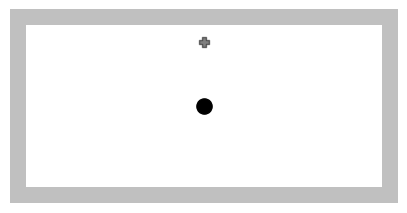

In [10]:
import matplotlib.animation as animation
prey_markers = ['P', 'X']

# Colormaps 
from matplotlib import colors
import matplotlib.cm as cm

cmap_wall = cm.binary
cmap_wall.set_under('k', alpha=0)

cmap_ch0 = colors.LinearSegmentedColormap.from_list(
    "", ["white", "xkcd:ultramarine"]
)

cmap_ch1 = colors.LinearSegmentedColormap.from_list(
    "", ["white", "xkcd:magenta"]
)

fig, ax = plt.subplots()

# Environment 
plt.imshow(1 - env_log[0][:, :, -1], clim=[0.1,1.0], cmap=cmap_wall, alpha=0.25, zorder=1)
#plt.imshow((cmap_ch0(env_log[1][:,:,0]) + cmap_ch1(env_log[1][:,:,1]))/2)#, interpolation='gaussian', zorder=0) 


# Adjust axes 
plt.xlim([(pk//2) - 1, width + pk//2])
plt.ylim([height + pk//2, (pk//2) - 1]) 
plt.axis("off")

# Initial data 
agnt_animation = ax.scatter([], [], s=120, color='k', zorder=3)
preys_animation = [[] for _ in preys]
for a, prey in enumerate(preys): 
    if scenario == "Static":
     preys_animation[a] = ax.scatter([], [], s=60, color='k', alpha=0.5, marker=prey_markers[prey.cues], zorder=2)
    elif scenario != "Static": 
        preys_animation[a] = ax.scatter([], [], s=60, color='k', alpha=0.5, marker=prey_markers[0], zorder=2)

# Animate 
def update_animation(t):
    plt.imshow((cmap_ch0(env_log[t][:,:,0]) + cmap_ch1(env_log[t][:,:,1]))/2, interpolation='gaussian', zorder=0) 

    agnt_animation.set_offsets([path[t, 1], path[t, 0]])

    for a, prey in enumerate(preys): 
        try:
            preys_animation[a].set_offsets([prey.path[t][1], prey.path[t][0]])
        except:
            preys_animation[a].set(alpha=0)

anim = animation.FuncAnimation(fig, update_animation, frames=range(0, len(path)), blit=False)
anim.save("Test.gif", dpi=300)


In [ ]:
# 2 channel colormap
input_values = np.linspace(0,1,num=11)
a,b = np.meshgrid(input_values, input_values)

plt.imshow((cmap_ch0(a) + cmap_ch1(b))/2, zorder=0, origin='lower')
plt.xticks(ticks=range(len(input_values)), labels=np.round(input_values,1), rotation='vertical')
plt.yticks(ticks=range(len(input_values)), labels=np.round(input_values,1))
plt.xlabel('Ch0 input')
plt.ylabel('Ch1 input')

## Fitness vs case

In [ ]:
# Fitness vs case
noise = 0
cases = ["1", "2", "3"]
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
results = np.zeros((len(cases), len(policies)))

# Test agents
for a, case in enumerate(cases):
    for b, policy in enumerate(policies): 
        if policy in multimodal_mazes.AgentRuleBased.policies:
            agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
        elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
            agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
            agnt.alpha = 0.6
        elif policy == "Levy":
            agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

        fitness, _, _, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=cases[a], motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=pm, pe=pe)

        results[a, b] = fitness

for b, policy in enumerate(policies): 
    plt.plot(cases, results[:,b], color=colors[b], label=policy)

plt.title(f"{motion}, {multisensory} - Fitness vs Case")
plt.ylim([0, 1.05])
plt.ylabel('Fitness')
plt.xlabel('Case')
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), labels=policies)

## Fitness vs speed per case

In [ ]:
# Fitness vs speed
noise = 0
cases = ["1", "2", "3"]
speeds = np.linspace(start=0.0, stop=1.0, num=10)
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
results = np.zeros((len(speeds), len(policies)))

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{motion}, {multisensory} - Fitness vs Speed")


# Test agents
for case in range(len(cases)):
    for a, speed in enumerate(speeds):
        for b, policy in enumerate(policies): 
            if policy in multimodal_mazes.AgentRuleBased.policies:
                agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
            elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
                agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
                agnt.alpha = 0.6
                
            elif policy == "Levy":
                agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

            fitness, _, _, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=cases[case], motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=speeds[a], pe=pe)
            results[a, b] = fitness
    

    for b, policy in enumerate(policies): 
        axs[case].plot(speeds, results[:,b], color=colors[b])    
        axs[case].set_title(f"Case {case+1}")

axs[0].set(xlabel='Speed', ylabel='Fitness')
axs[0].set_xticks(np.arange(0.0, 1.1, 0.2));
fig.legend(loc='center right', bbox_to_anchor=(1.05, 0.5), labels=policies)

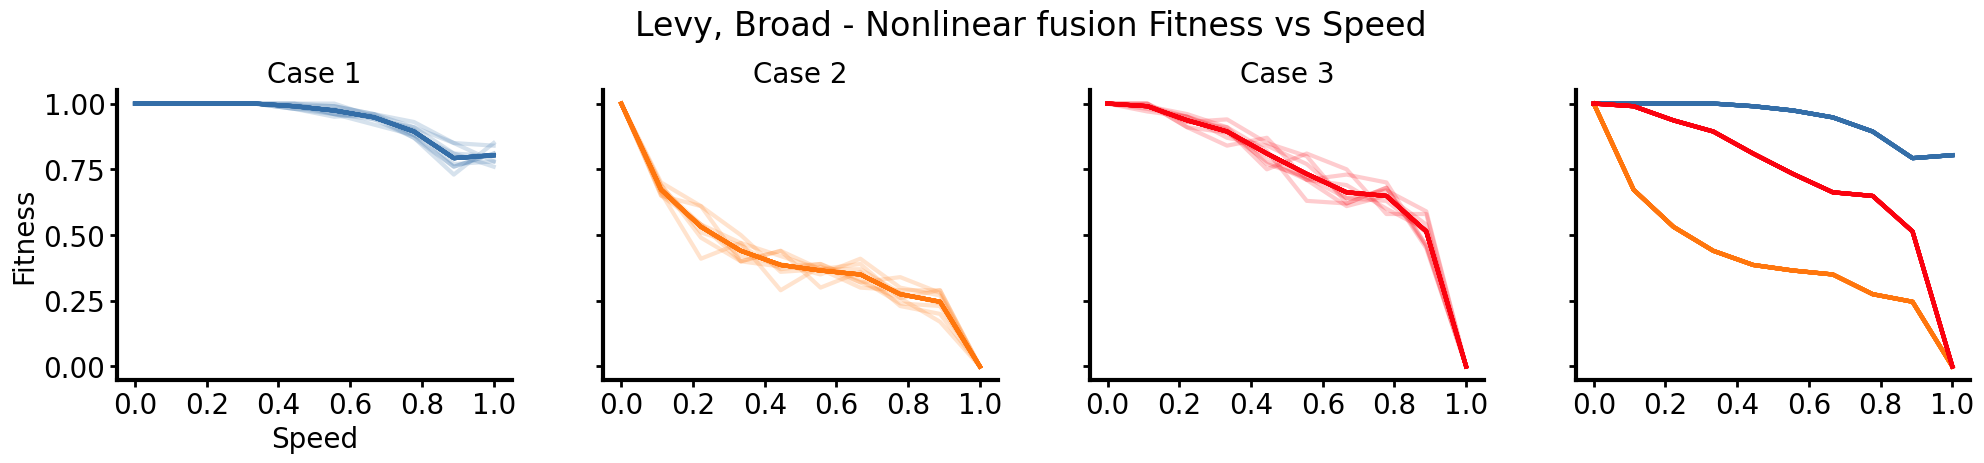

In [11]:
# Fitness vs speed
noise = 0
repeats = [i for i in range(8)]
cases = ["1", "2", "3"]
speeds = np.linspace(start=0.0, stop=1.0, num=10)
policy = multimodal_mazes.AgentRuleBased.policies[7]
agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
results = np.zeros((len(speeds), len(repeats)))

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{motion}, {multisensory} - {policy} Fitness vs Speed")

for case in range(len(cases)):
    mean_fitness = []
    for a, speed in enumerate(speeds):
        sum_fitness = 0
        for b in repeats:
            fitness, _, _, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=cases[case], motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=speeds[a], pe=pe)
            
            results[a, b] = fitness
            sum_fitness+=fitness
        if sum_fitness == 0:
            mean_fitness.append(sum_fitness)
        else:
            mean_fitness.append(sum_fitness/len(repeats))
        
    for b in repeats:
        axs[case].plot(speeds, results[:,b], color=colors[case], alpha=0.2)    
        axs[case].set_title(f"Case {case+1}")
        axs[case].plot(speeds, mean_fitness, color=colors[case])
        axs[3].plot(speeds, mean_fitness, color=colors[case])

axs[0].set(xlabel='Speed', ylabel='Fitness')
axs[0].set_xticks(np.arange(0.0, 1.1, 0.2));

## Disappearing Fitness vs speed

In [ ]:
# Fitness vs speed
noise = 0
speeds = np.linspace(start=0.0, stop=1.0, num=10)
visible_periods = [50, 10, 5, 4, 3, 2, 1, 0]
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
results = np.zeros((len(speeds), len(policies)))

fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])

fig2, axs2 = plt.subplots(2, 4, figsize=(20, 5), sharex=True, sharey=True)

# Test agents
for period in range(len(visible_periods)):
    for a, speed in enumerate(speeds):
        for b, policy in enumerate(policies): 
            if policy in multimodal_mazes.AgentRuleBased.policies:
                agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
            elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
                agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
                agnt.alpha = 0.6
            elif policy == "Levy":
                agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

            fitness, _, _, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=visible_periods[period], multisensory=multisensory, pc=pc, pm=speeds[a], pe=pe)
            results[a, b] = fitness
    
    idy = 0
    idx = period 
    auc = np.trapz(y=results.T, x=speeds, axis=1)

    if period >= 4:
        idy = 1
        idx = period - 4

    for b, policy in enumerate(policies): 
        axs[idy][idx].plot(speeds, results[:,b], color=colors[b])    
        axs[idy][idx].set_title(f"Time to Disappear {visible_periods[period]}")  
        axs2[idy][idx].set_title(f"Time to Disappear {visible_periods[period]}")  
        ml, sl, _ = axs2[idy][idx].stem(b, auc[b] - auc[0])
        ml.set_color(colors[b])
        sl.set_color(colors[b])
    
    axs2[idy][idx].set_xticks(range(len(policies)), policies, rotation='vertical')
    axs2[idy][idx].set_ylabel('AUC');

axs[0][0].set(xlabel='Speed', ylabel='Fitness')
axs[0][0].set_xticks(np.arange(0.0, 1.1, 0.2));
fig.subplots_adjust(0, 0.05, 1, 0.95)
fig.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), labels=policies)


## Disappearing Fitness vs visible time

In [ ]:
# Fitness vs visible time steps
noise = 0
cases = ["1", "2", "3"]
visible_periods = [7, 6, 5, 4, 3, 2, 1, 0]
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
results = np.zeros((len(visible_periods), len(policies)))

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{motion}, {multisensory} - Fitness vs Time to Disappear")

fig2, axs2 = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig2.suptitle(f"{motion}, {multisensory} - Fitness vs Time to Disappear AUC")

# Test agents
for c, case in enumerate(cases):
    for a, period in enumerate(visible_periods):
        if period == 6:
            period = 10
        elif period == 7:
            period = 50
        for b, policy in enumerate(policies): 
            if policy in multimodal_mazes.AgentRuleBased.policies:
                agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
            elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
                agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
                agnt.alpha = 0.6
            elif policy == "Levy":
                agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

            fitness, _, _, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=period, pc=pc, pm=pm, pe=pe)
            results[a, b] = fitness
    
    auc = np.trapz(y=results.T, x=visible_periods, axis=1)

    for b, policy in enumerate(policies): 
        axs[c].plot(visible_periods, results[:,b], color=colors[b])    
        axs[c].set_title(f"Case {case}")

        ml, sl, _ = axs2[c].stem(b, auc[0] - auc[b])
        ml.set_color(colors[b])
        sl.set_color(colors[b])

    axs2[c].set_xticks(range(len(policies)), policies, rotation='vertical')
    axs2[c].set_ylabel('AUC');

axs[0].set(xlabel='Time to Disappear', ylabel='Fitness', )
visible_periods_str = ['0', '1', '2', '3', '4', '5', '10', '50']
axs[0].set_xticks(range(8), visible_periods_str);
axs[0].xaxis.set_inverted(True)
fig.legend(loc='center right', bbox_to_anchor=(1.05, 0.5), labels=policies)

In [ ]:
# Fitness vs visible time steps
noise = 0
repeats = [i for i in range(10)]
cases = ["1", "2", "3"]
visible_periods = [7, 6, 5, 4, 3, 2, 1, 0]
# policy = multimodal_mazes.AgentRuleBasedMemory.policies[0]
# agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
policy = multimodal_mazes.AgentRuleBased.policies[7]
agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
results = np.zeros((len(visible_periods), len(repeats)))

# Test agents
for a, case in enumerate(cases):
    mean_fitness = []
    std_fitness = []
    for b, period in enumerate(visible_periods):
        if period == 6:
            period = 10
        elif period == 7:
            period = 50

        fitness_vals = []
        
        for c in repeats:
            fitness, _, _, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=period, multisensory=multisensory, pc=pc, pm=pm, pe=pe)
            results[b, c] = fitness
            fitness_vals.append(fitness)
            #print(fitness)
        mean_fitness.append(np.mean(fitness_vals))
        std_fitness.append(np.std(fitness_vals))
    
    for c in repeats:
        plt.plot(visible_periods, results[:,c], color=colors[a], alpha=0.2)    
    
    plt.errorbar(visible_periods, mean_fitness, yerr=std_fitness, color=colors[a], label = case)

plt.title(f"{motion}, {multisensory} - {policy} Fitness vs Time to Disappear")  
plt.xlabel("Time to Disappear")
plt.ylabel("Fitness")
visible_periods_str = ['0', '1', '2', '3', '4', '5', '10', '50']
plt.xlim([7, 0])
plt.xticks(range(8), visible_periods_str);